In [1]:
import pandas as pd
import numpy as np
import time
import sys
from pycaret.classification import *

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='../supervised_contrastive_learning/FT-Transformer/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from evaluation import *
    
from data_provider import data_split

In [2]:
dataset = pd.read_csv('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz', compression='gzip')
mimic_train_ori, mimic_valid_ori = data_split(dataset, 393, 0.7, Threshold=0.05, n_trial=1, mode = 'mimic') 

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: 0    437041
1     41871
2     11988
3    168043
Name: classes, dtype: int64
테스트셋 클래스 비율: 0    175017
1     17691
2      5001
3     70832
Name: classes, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.66:0.06:0.02:0.26
테스트셋 클래스 비율: 0.65:0.07:0.02:0.26
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 5982
테스트셋 환자 수: 2564
학습셋 체류 수: 6214
테스트셋 체류 수: 2669
--------------------------------------
========== 실험 설정 ==========
분할 시드: 393
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.66
시도한 시행 횟수: 0


In [16]:
eicu = pd.read_csv('/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eICU.csv.gz', compression='gzip')
eicu = eicu.rename(columns = {'SaO2_fillna':'SpO2_fillna'})
eicu_train_ori, eicu_valid_ori = data_split(eicu, 4903, 0.7, Threshold=0.05, n_trial=1, mode = 'eicu') 

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: 0    265279
1     32097
2      4351
3     96156
Name: classes, dtype: int64
테스트셋 클래스 비율: 0    112893
1     14007
2      1835
3     42628
Name: classes, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.67:0.08:0.01:0.24
테스트셋 클래스 비율: 0.66:0.08:0.01:0.25
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 3552
테스트셋 환자 수: 1523
학습셋 체류 수: 3644
테스트셋 체류 수: 1564
--------------------------------------
========== 실험 설정 ==========
분할 시드: 4903
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.40
시도한 시행 횟수: 0


In [18]:
# for training: circ 상태 10% 포함 

circ_data = mimic_train_ori[mimic_train_ori['Annotation'] == 'circ']
circ_data_sample = circ_data.sample(frac=0, random_state=1) 

non_circ_data = mimic_train_ori[(mimic_train_ori['Annotation'] != 'circ')]
new_dataset = pd.concat([circ_data_sample, non_circ_data])

sampled_dataset = new_dataset.reset_index(drop=True)

In [19]:
X_train, y_train, _ = split_X_Y(sampled_dataset, mode = 'mimic')
X_valid, y_valid, valid_output = split_X_Y(mimic_valid_ori, mode = 'mimic')
X_test, y_test, test_output = split_X_Y(eicu_valid_ori, mode = 'eicu')

In [20]:
lgbm_wrapper = LGBMClassifier(n_estimators=10, random_state=42)
lgbm_wrapper.fit(X_train, y_train)

valid_preds = lgbm_wrapper.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_valid)[:, 1]

test_preds = lgbm_wrapper.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_test)[:, 1]
# pred_proba = lgbm_wrapper.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 41871, number of negative: 437041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31527
[LightGBM] [Info] Number of data points in the train set: 478912, number of used features: 215
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087429 -> initscore=-2.345434
[LightGBM] [Info] Start training from score -2.345434


In [21]:
print('Accuracy: %.3f' % accuracy_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Precision: %.3f' % precision_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Recall: %.3f' % recall_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('--')
print('Accuracy: %.3f' % accuracy_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Precision: %.3f' % precision_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Recall: %.3f' % recall_score(test_output.Shock_next_12h, test_output.prediction_label))

Accuracy: 0.932
Precision: 0.966
Recall: 0.831
--
Accuracy: 0.926
Precision: 0.945
Recall: 0.827


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

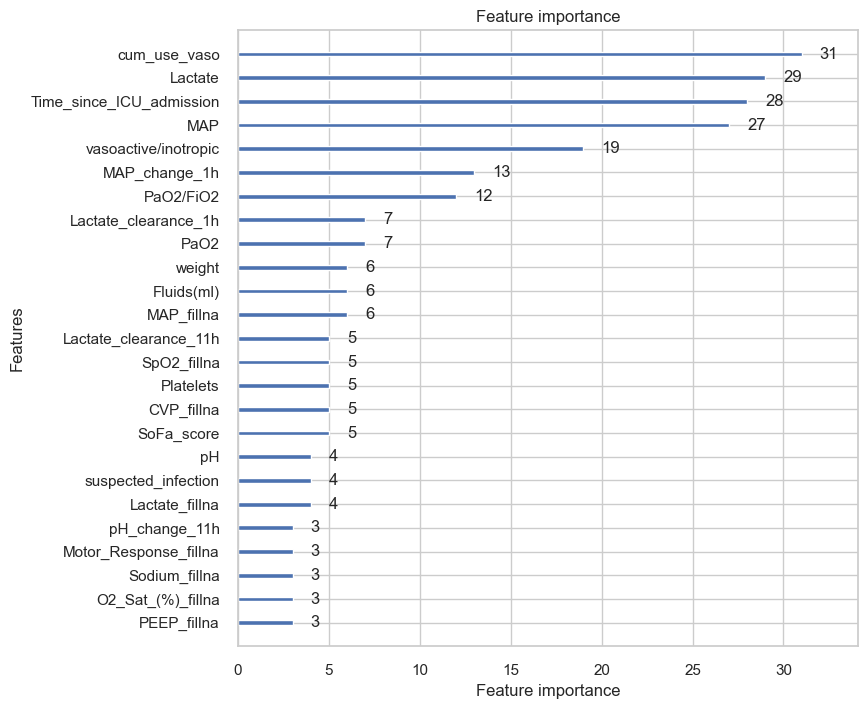

In [22]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8,8))
plot_importance(lgbm_wrapper, max_num_features = 25, ax = ax)

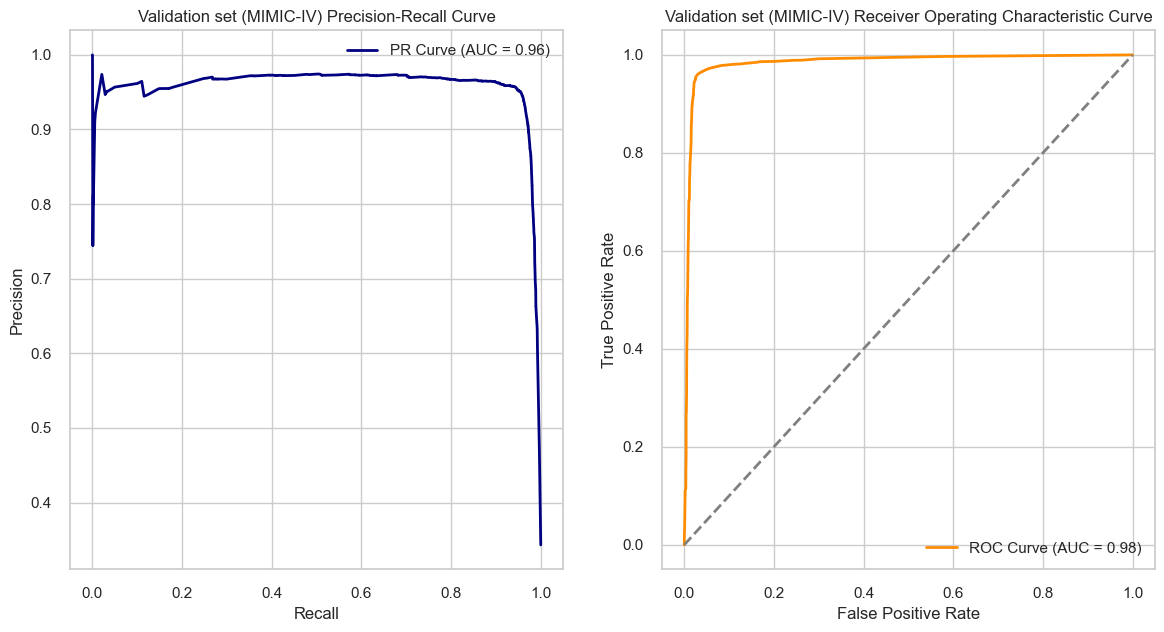

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
sns.set(style="whitegrid")

# PR Curve 계산
precision, recall, _ = precision_recall_curve(valid_output.Shock_next_12h, valid_output.prediction_prob)
pr_auc = auc(recall, precision)

# ROC Curve 계산
fpr, tpr, _ = roc_curve(valid_output.Shock_next_12h, valid_output.prediction_prob)
roc_auc = auc(fpr, tpr)

# PR Curve 그리기
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='navy', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation set (MIMIC-IV) Precision-Recall Curve')
plt.legend(loc='best')

# ROC Curve 그리기
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation set (MIMIC-IV) Receiver Operating Characteristic Curve')
plt.legend(loc='best')

plt.show()

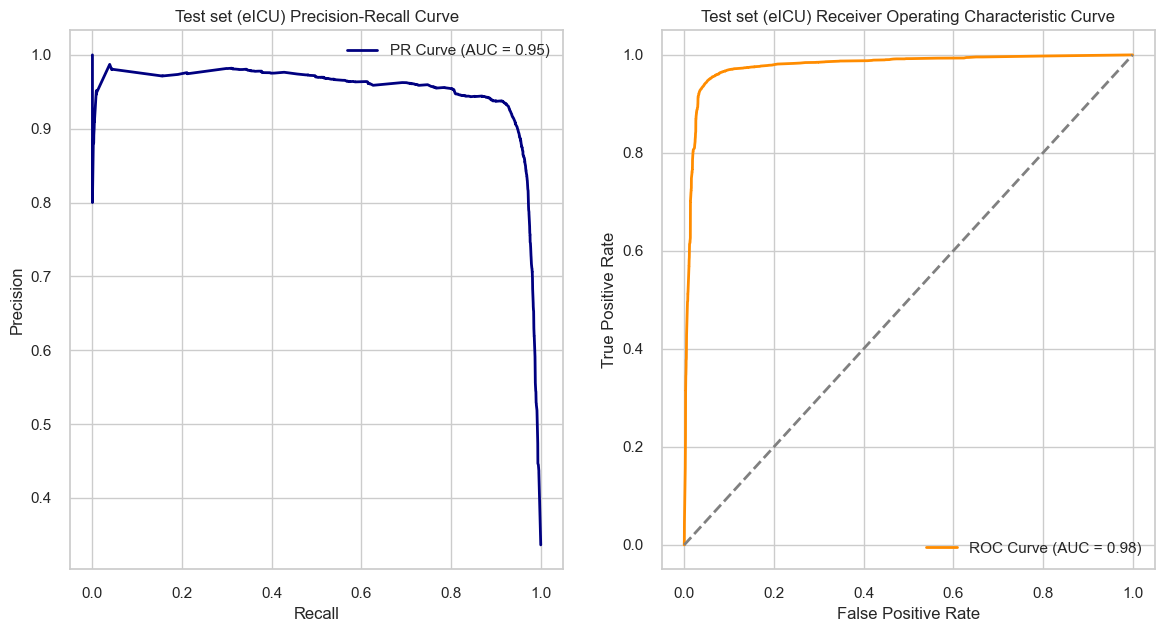

In [24]:
# PR Curve 계산
precision, recall, _ = precision_recall_curve(test_output.Shock_next_12h, test_output.prediction_prob)
pr_auc = auc(recall, precision)

sns.set(style="whitegrid")

# ROC Curve 계산
fpr, tpr, _ = roc_curve(test_output.Shock_next_12h, test_output.prediction_prob)
roc_auc = auc(fpr, tpr)

# PR Curve 그리기
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='navy', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test set (eICU) Precision-Recall Curve')
plt.legend(loc='best')

# ROC Curve 그리기
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test set (eICU) Receiver Operating Characteristic Curve')
plt.legend(loc='best')

plt.show()

In [26]:
model = LogisticRegression(random_state = 42) 
model.fit(X_train, y_train)

valid_preds = model.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = model.predict_proba(X_valid)[:, 1]

test_preds = model.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = model.predict_proba(X_test)[:, 1]

In [27]:
print('Accuracy: %.3f' % accuracy_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Precision: %.3f' % precision_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Recall: %.3f' % recall_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('--')
print('Accuracy: %.3f' % accuracy_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Precision: %.3f' % precision_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Recall: %.3f' % recall_score(test_output.Shock_next_12h, test_output.prediction_label))

Accuracy: 0.657
Precision: 0.908
Recall: 0.001
--
Accuracy: 0.649
Precision: 0.281
Recall: 0.029


In [29]:
C = 1               

model = svm.LinearSVC(C=C, max_iter = 10, random_state=42)  
model.fit(X_train, y_train)

valid_preds = model.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = model.predict_proba(X_valid)[:, 1]

test_preds = model.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = model.predict_proba(X_test)[:, 1]

In [ ]:
print('Accuracy: %.3f' % accuracy_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Precision: %.3f' % precision_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('Recall: %.3f' % recall_score(valid_output.Shock_next_12h, valid_output.prediction_label))
print('--')
print('Accuracy: %.3f' % accuracy_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Precision: %.3f' % precision_score(test_output.Shock_next_12h, test_output.prediction_label))
print('Recall: %.3f' % recall_score(test_output.Shock_next_12h, test_output.prediction_label))